In [1]:
import os
import random
import torch
import torchvision.transforms as standard_transforms
import scipy.io as sio
import matplotlib
import pandas as pd
import misc.transforms as own_transforms
import warnings
import CCAugmentation as cca

from torch.autograd import Variable
from torch.utils.data import DataLoader
from misc import pytorch_ssim
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from tqdm import trange, tqdm
from misc.utils import *
from models.M2TCC import CrowdCounter
from config import cfg
from datasets.SHHB.setting import cfg_data
from load_data import CustomDataset

torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True
warnings.filterwarnings('ignore')

In [2]:
# model_path = './exp/11-26_17-34_SHHB_SANet_0.0001_[noAug]/all_ep_071_mae_24.71_mse_38.16.pth'
# model_path = './exp/11-30_16-21_SHHB_SANet_0.0001_[flip+crop]/all_ep_293_mae_20.62_mse_31.96.pth'
# model_path = './exp/12-04_06-44_SHHB_SANet_1e-05_[flip+crop]/all_ep_410_mae_41.08_mse_57.29.pth'
# model_path = './exp/12-04_12-27_SHHB_SANet_0.0001_[flip+cutout]/all_ep_061_mae_21.14_mse_39.46.pth'
# model_path = './exp/12-05_15-43_SHHB_SANet_0.0001_[flip+cutout]/all_ep_051_mae_19.90_mse_35.96.pth'
model_path = './exp/12-05_19-05_SHHB_SANet_0.0001_[flip+cutout]/all_ep_051_mae_25.53_mse_39.51.pth'

loss_1_fn = nn.MSELoss()
loss_2_fn = pytorch_ssim.SSIM(window_size=11)

net = CrowdCounter(cfg.GPU_ID,'SANet',loss_1_fn,loss_2_fn)
net.load_state_dict(torch.load(model_path))
net.cuda()
net.eval()              


val_pipeline = cca.Pipeline(
        cca.examples.loading.SHHLoader("/dataset/ShanghaiTech", "test", "B"), []
    ).execute_generate()
val_loader = DataLoader(CustomDataset(val_pipeline), batch_size=cfg_data.VAL_BATCH_SIZE, num_workers=1, drop_last=False)

val_img = list(val_loader)

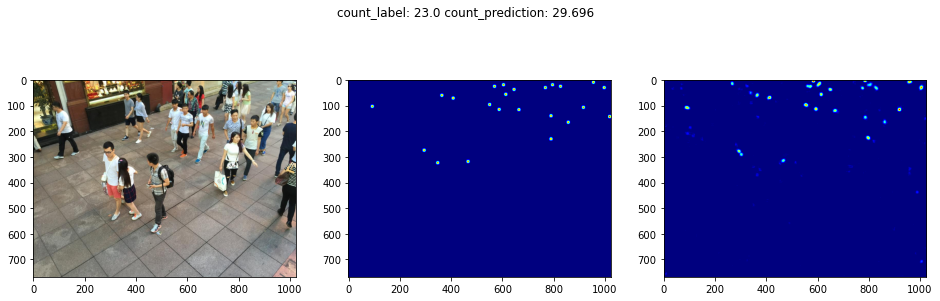

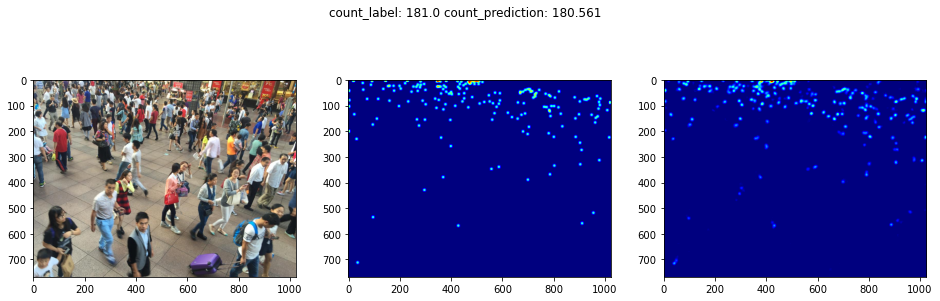

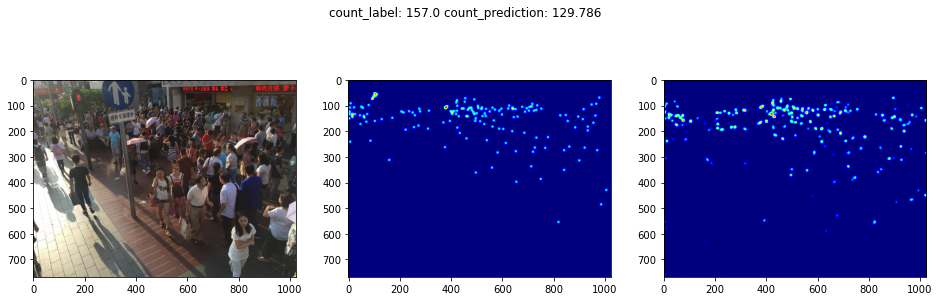

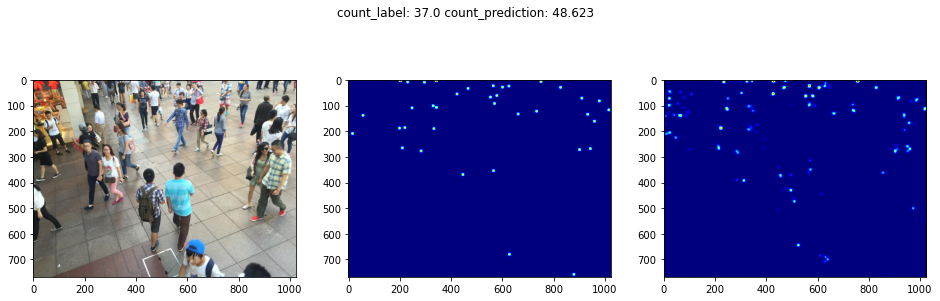

In [3]:
start = 0
N = 4

for vi, data in enumerate(val_img[start:start+N], 0):
    img, gt_map = data

    with torch.no_grad():
        img = Variable(img).cuda()
        pred_map = net.test_forward(img)
        pred_map = pred_map.data.cpu().numpy()
        
    new_img = img.data.cpu().numpy()
    new_img = np.moveaxis(new_img, 1, 2)
    new_img = np.moveaxis(new_img, 2, 3)
    new_img = np.squeeze(new_img)[:,:,::-1]
    
    pred_cnt = np.sum(pred_map[0])/100.0
    gt_count = np.sum(gt_map.data.cpu().numpy())/100.0
    
    fg, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 5))
    plt.suptitle(' '.join([
            'count_label:', str(round(gt_count, 3)),
            'count_prediction:', str(round(pred_cnt, 3))
        ]))
    ax0.imshow(np.uint8(new_img))
    ax1.imshow(np.squeeze(gt_map), cmap='jet')
    ax2.imshow(np.squeeze(pred_map), cmap='jet')
    plt.show()

In [4]:
mae = np.empty(len(val_img))
mse = np.empty(len(val_img))
for vi, data in enumerate(tqdm(val_img), 0):
    img, gt_map = data

    with torch.no_grad():
        img = Variable(img).cuda()
        pred_map = net.test_forward(img)
        pred_map = pred_map.data.cpu().numpy()
    
    pred_cnt = np.sum(pred_map[0])/100.0
    gt_count = np.sum(gt_map.data.cpu().numpy())/100.0
    mae[vi] = np.abs(gt_count-pred_cnt)
    mse[vi] = (gt_count-pred_cnt)**2
    
print('MAE:', round(mae.mean(),2))
print('MSE:', round(np.sqrt(mse.mean()),2))

100%|██████████| 316/316 [00:18<00:00, 16.74it/s]

MAE: 18.06
MSE: 26.52
